In [1]:
from RNN_QSR import *

cuda:0


In [2]:
class PE2D(nn.Module):
    def __init__(self, d_model, Lx,Ly,device,n_encode=None):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(Lx*Ly, d_model)
        
        if type(n_encode)==type(None):
            n_encode=3*d_model//4
        for pos in range(Lx*Ly):
            x=pos//Ly
            y=pos%Ly
            # Only going to fill 3/4 of the matrix so the
            # occupation values are preserved
            for i in range(0, n_encode, 4):
                
                #x direction encoding
                pe[pos, i] = \
                math.sin(x / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 1] = \
                math.cos(x / (10000 ** ((2 * (i + 1))/n_encode)))
                #y direction encoding
                pe[pos, i+2] = \
                math.sin(y / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 3] = \
                math.cos(y / (10000 ** ((2 * (i + 1))/n_encode)))
                
        self.pe = pe.unsqueeze(0).to(device)
        self.L=Lx*Ly
    
    def forward(self, x):
        return x + self.pe[:,:self.L,:]

In [3]:
class SlowTransformer(Sampler):
    def __init__(self,Lx,Ly,device=device,Nh=128,decoder=False,dropout=0.0,num_layers=3, **kwargs):
        super(SlowTransformer, self).__init__(device=device)
        
        self.pe = PE2D(Nh, Lx,Ly,device)
        
        if decoder:
            #Decoder only transformer
            self.decoder_layer = nn.TransformerDecoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        else:
            #Encoder only transformer
            #misinterperetation on encoder made it so this code does not work
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,1),
                nn.Sigmoid()
            )
        
        
        self.set_mask(Lx*Ly)
        self.to(device)
        
    def set_mask(self, L):
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones(L,L))).to(device)
        self.pe.L=L

    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]!=self.L:
            self.set_mask(input.shape[1])
        
        input=self.pe(input).transpose(1,0)
        output = self.transformer(input,self.mask)
        output = self.lin(output.transpose(1,0))
        return output
    
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        
        #probability predictions may be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=self.device)
        
        self.set_mask(L)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]   
            #encode the input to the proper shape
            encoded_input = input[:,:idx,:]+self.pe.pe[:,:idx,:]
                        
            #Get transformer output
            output = self.transformer(encoded_input.transpose(1,0),self.mask[:idx,:idx])
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(output.transpose(1,0)[:,-1,:])
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]

In [4]:
#Settings
op=Opt()
Lx=8
op.L=Lx*Lx
op.Nh=64
op.lr=5e-4
op.Q=1
op.K=32
op.USEQUEUE=0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q
print(op)

L                             			64
Q                             			1
K                             			32
B                             			32
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			0
NLOOPS                        			1
hamiltonian                   			Rydberg
steps                         			12000
dir                           			out
Nh                            			64
lr                            			0.0005



In [5]:
trainsformer = SlowTransformer(Lx,Lx,Nh=op.Nh,num_layers=2)
sampleformer= SlowTransformer(Lx,Lx,Nh=op.Nh,num_layers=2)
beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)


In [6]:
print(sum (p.numel () for p in trainsformer.parameters ()))

847681


In [7]:
# train a gru
op.dir="GRU"
trainrnn,optimizer=new_rnn_with_optim("GRU",459,lr=op.lr)
print(sum (p.numel () for p in trainrnn.parameters ()))
reg_train(op,(trainrnn,optimizer))

847774
Output folder path established
-0.40522 64
1,2.10|45,-0.31|89,-0.33|134,-0.38|178,-0.40|223,-0.39|267,-0.40|312,-0.39|356,-0.39|400,-0.40|445,-0.40|489,-0.40|533,-0.41|578,-0.40|622,-0.40|667,-0.40|711,-0.40|756,-0.40|800,-0.40|844,-0.41|889,-0.41|933,-0.41|978,-0.40|1022,-0.41|1067.2162992954254 12000


In [8]:
Lx=4
op.L=Lx*Lx
op.dir="GRU"
trainrnn,optimizer=new_rnn_with_optim("GRU",320,lr=op.lr)
print(sum (p.numel () for p in trainrnn.parameters ()))
reg_train(op,(trainrnn,optimizer))

413121
Output folder path established
-0.45776822 16
0,2.01|5,-0.38|10,-0.42|15,-0.44|20,-0.45|25,-0.45|31,-0.45|36,-0.45|41,-0.46|46,-0.45|51,-0.46|56,-0.45|61,-0.45|66,-0.46|71,-0.46|76,-0.46|82,-0.46|87,-0.44|92,-0.45|97,-0.46|102,-0.46|107,-0.45|112,-0.45|117,-0.46|122.32494974136353 12000


In [7]:



#op.steps=4000
op.dir="TF"


if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-0.40522 64
0,2.38|133,-0.31|267,-0.30|400,-0.35|536,-0.37|670,-0.40|804,-0.41|938,-0.41|1072,-0.41|1206,-0.40|1340,-0.41|1474,-0.41|1609,-0.41|1743,-0.41|1877,-0.41|2011,-0.41|2146,-0.41|2285,-0.42|2426,-0.41|2560,-0.40|2695,-0.41|2829,-0.41|2963,-0.41|3097,-0.41|3231.5833308696747 12000


In [8]:
torch.arange(4*4).reshape([4,4,1]) + torch.ones([1,4,4])

tensor([[[ 1.,  1.,  1.,  1.],
         [ 2.,  2.,  2.,  2.],
         [ 3.,  3.,  3.,  3.],
         [ 4.,  4.,  4.,  4.]],

        [[ 5.,  5.,  5.,  5.],
         [ 6.,  6.,  6.,  6.],
         [ 7.,  7.,  7.,  7.],
         [ 8.,  8.,  8.,  8.]],

        [[ 9.,  9.,  9.,  9.],
         [10., 10., 10., 10.],
         [11., 11., 11., 11.],
         [12., 12., 12., 12.]],

        [[13., 13., 13., 13.],
         [14., 14., 14., 14.],
         [15., 15., 15., 15.],
         [16., 16., 16., 16.]]])

In [9]:
pe = PE2D(40,6,6,torch.device('cpu')).pe
print(pe.shape,pe.max())

torch.Size([1, 36, 40]) tensor(1.)


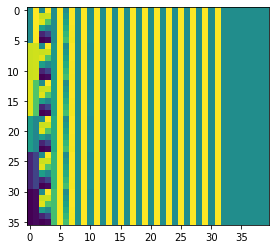

In [10]:
plt.imshow(pe[0])

In [11]:
torch.zeros([1,2,3]).transpose(1,0)

tensor([[[0., 0., 0.]],

        [[0., 0., 0.]]])